In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/GB_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CAvideos.csv


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from prophet import Prophet
import re


In [3]:
import os
import pandas as pd

# List files in the directory
dataset_path = '/kaggle/input/youtube-new'
files = os.listdir(dataset_path)
print("Files in the directory:", files)

# Load the US dataset
file_path = os.path.join(dataset_path, 'USvideos.csv')
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())

Files in the directory: ['GBvideos.csv', 'MXvideos.csv', 'KRvideos.csv', 'MX_category_id.json', 'GB_category_id.json', 'US_category_id.json', 'IN_category_id.json', 'DEvideos.csv', 'KR_category_id.json', 'RU_category_id.json', 'FRvideos.csv', 'USvideos.csv', 'INvideos.csv', 'RUvideos.csv', 'CA_category_id.json', 'DE_category_id.json', 'JP_category_id.json', 'JPvideos.csv', 'FR_category_id.json', 'CAvideos.csv']
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning 

In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

# Drop duplicates
df = df.drop_duplicates()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64


In [5]:
# Clean the tags column
df['tags'] = df['tags'].apply(lambda x: x.replace('|', ' '))

In [6]:
# Convert trending_date to datetime
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

# Convert publish_time to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


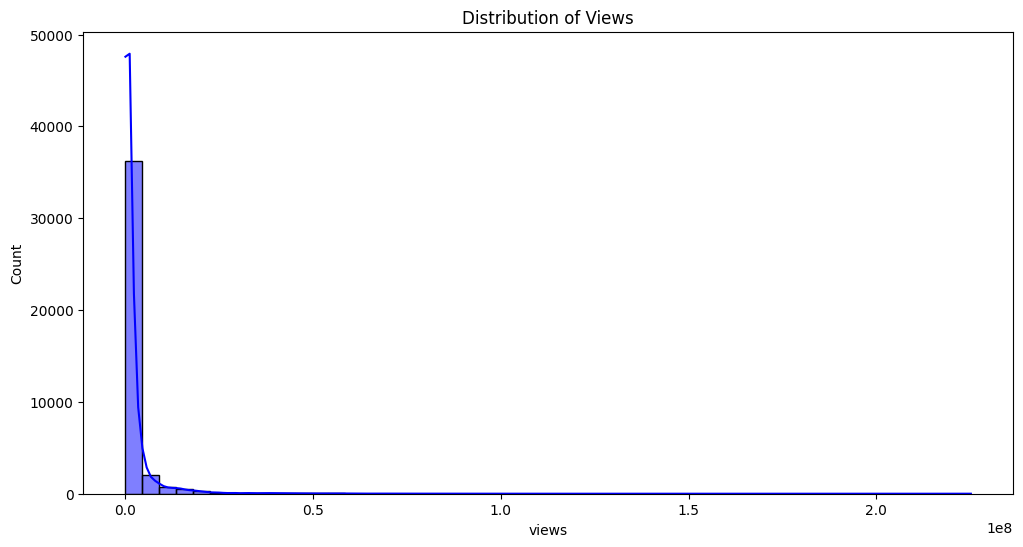

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


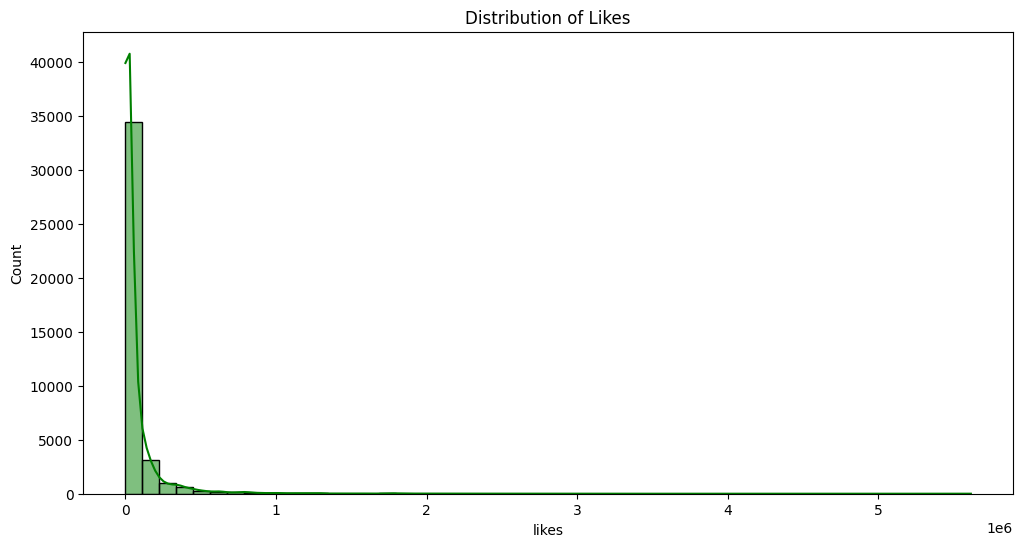

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


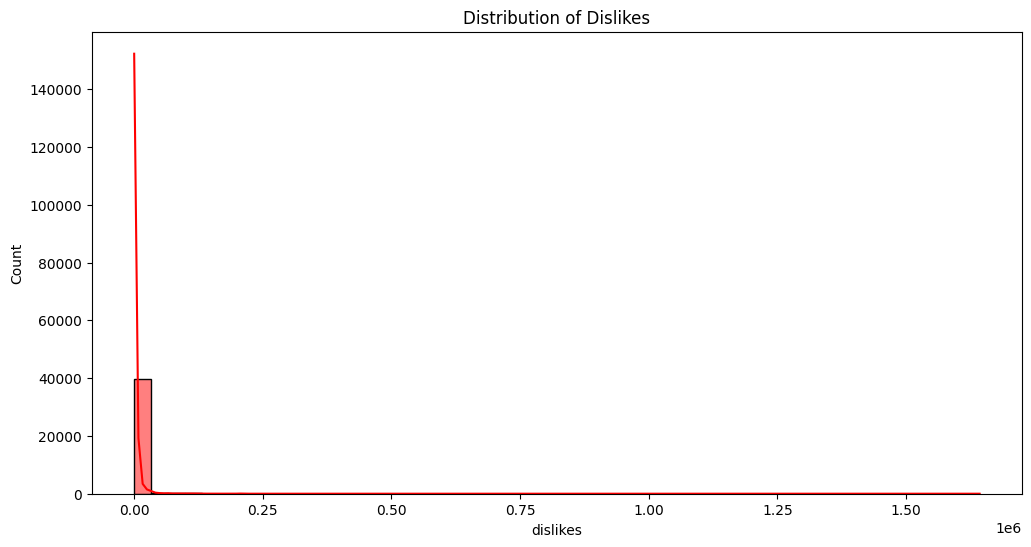

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


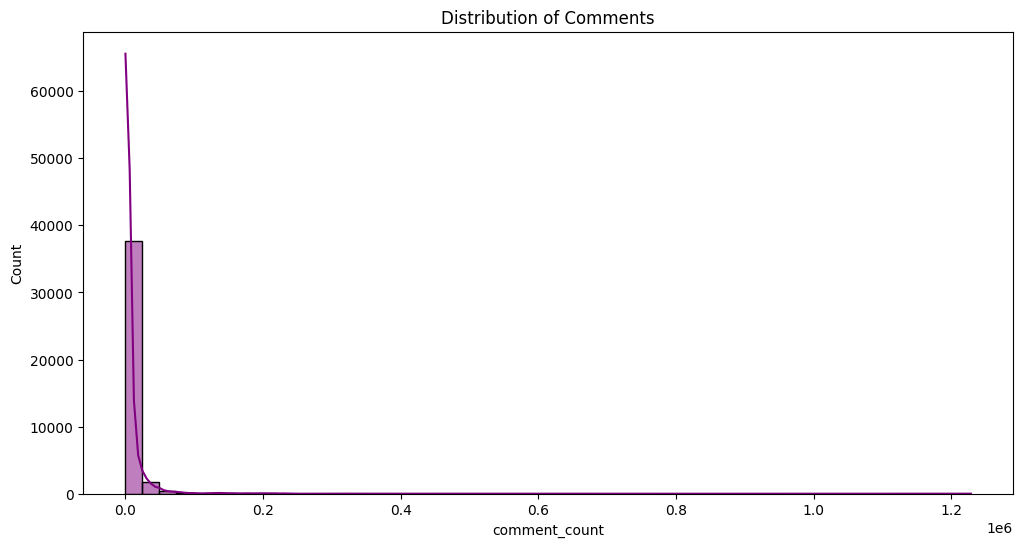

In [7]:
# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['views'], bins=50, kde=True, color='blue')
plt.title('Distribution of Views')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['likes'], bins=50, kde=True, color='green')
plt.title('Distribution of Likes')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['dislikes'], bins=50, kde=True, color='red')
plt.title('Distribution of Dislikes')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['comment_count'], bins=50, kde=True, color='purple')
plt.title('Distribution of Comments')
plt.show()

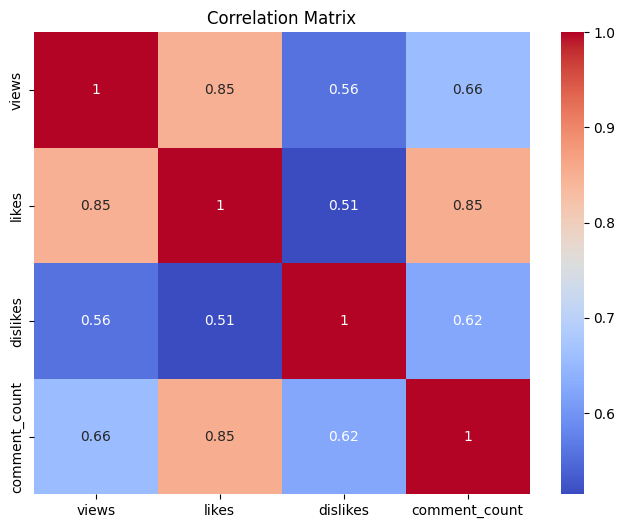

In [8]:
# Correlation matrix
corr_matrix = df[['views', 'likes', 'dislikes', 'comment_count']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

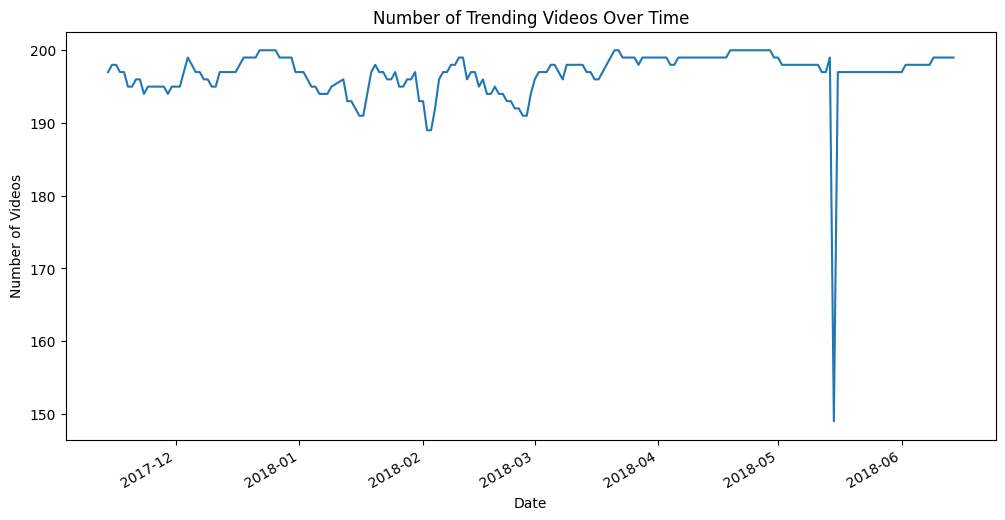

In [9]:
# Group by trending_date
trending_over_time = df.groupby('trending_date').size()

# Plot
plt.figure(figsize=(12, 6))
trending_over_time.plot()
plt.title('Number of Trending Videos Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Videos')
plt.show()

In [10]:
import re

# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Extract hashtags from title and tags
df['hashtags'] = df['title'].apply(extract_hashtags) + df['tags'].apply(extract_hashtags)

In [11]:
# Calculate engagement rate

df['engagement_rate'] = (df['likes'] + df['comment_count']) / df['views']

# Display the first 5 rows with the new column
print(df[['views', 'likes', 'comment_count', 'engagement_rate']].head())

     views   likes  comment_count  engagement_rate
0   748374   57527          15954         0.098188
1  2418783   97185          12703         0.045431
2  3191434  146033           8181         0.048321
3   343168   10172           2146         0.035895
4  2095731  132235          17518         0.071456


In [12]:

# Remove timezone information from publish_time
df['publish_time'] = df['publish_time'].dt.tz_localize(None)

# Calculate days since upload
df['days_since_upload'] = (df['trending_date'] - df['publish_time']).dt.days

# Display the first 5 rows
print(df[['trending_date', 'publish_time', 'days_since_upload']].head())

  trending_date        publish_time  days_since_upload
0    2017-11-14 2017-11-13 17:13:01                  0
1    2017-11-14 2017-11-13 07:30:00                  0
2    2017-11-14 2017-11-12 19:05:24                  1
3    2017-11-14 2017-11-13 11:00:04                  0
4    2017-11-14 2017-11-12 18:01:41                  1


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine title and tags
df['text'] = df['title'] + " " + df['tags']

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'])

In [14]:
# Define target variable
df['viral'] = (df['views'] > df['views'].median()).astype(int)

# Features
X = df[['engagement_rate', 'days_since_upload']]
y = df['viral']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56      3973
           1       0.56      0.55      0.56      4094

    accuracy                           0.56      8067
   macro avg       0.56      0.56      0.56      8067
weighted avg       0.56      0.56      0.56      8067



12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing


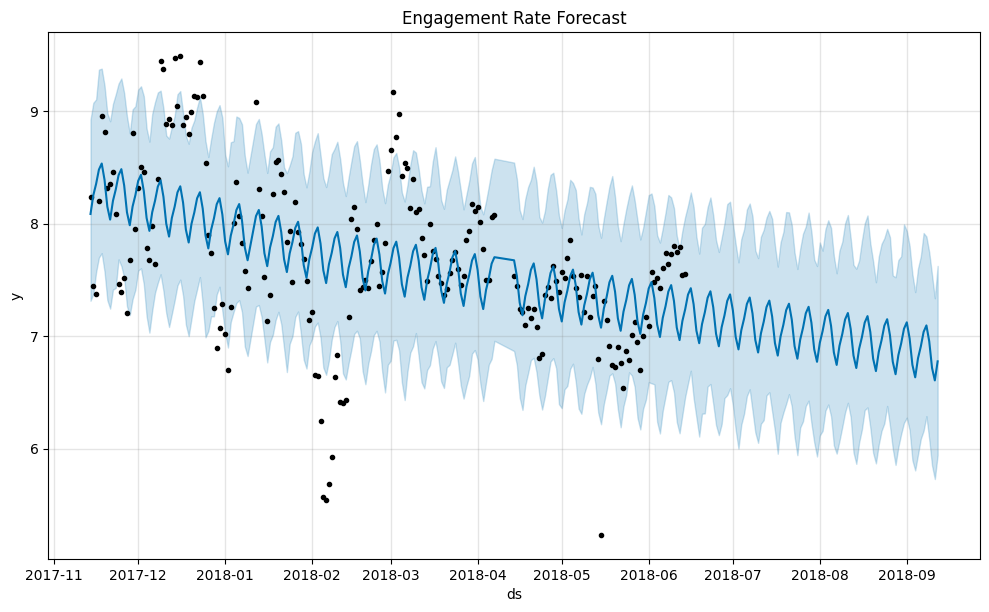

In [16]:
from prophet import Prophet

# Group by date and sum engagement rates
time_series_df = df.groupby('trending_date')['engagement_rate'].sum().reset_index()
time_series_df = time_series_df.rename(columns={'trending_date': 'ds', 'engagement_rate': 'y'})

# Train Prophet model
model = Prophet()
model.fit(time_series_df)

# Predict for the next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title('Engagement Rate Forecast')
plt.show()

In [17]:
from sklearn.cluster import KMeans

# Apply TF-IDF to text data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Display the first 5 rows with cluster labels
print(df[['text', 'cluster']].head())

                                                text  cluster
0  WE WANT TO TALK ABOUT OUR MARRIAGE SHANtell ma...        6
1  The Trump Presidency: Last Week Tonight with J...        6
2  Racist Superman | Rudy Mancuso, King Bach & Le...        6
3  Nickelback Lyrics: Real or Fake? rhett and lin...        9
4  I Dare You: GOING BALD!? ryan "higa" "higatv" ...        6


In [18]:
# Save the processed dataset to a CSV file
df.to_csv('processed_youtube_data.csv', index=False)

In [19]:
import joblib

# Save the Random Forest model
joblib.dump(clf, 'random_forest_model.pkl')

# Save the K-Means model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Save the Prophet model
joblib.dump(model, 'prophet_model.pkl')

['prophet_model.pkl']